<h1 align=center><font size = 5>算力不夠的問題 </h1 >


<h3>Objective for this Notebook</h3>    
<h5> 1. 在批量大小（batch size）受限的情況下，如何調整訓練過程以實現與更大批量訓練相同的效果，並確保梯度的有效性。</h5>



# Table of Contents
<li><a href="#ref0">梯度累積方法</a></li>
<li><a href="#ref1">與傳統方法比較</a></li>
<li><a href="#ref2">優化的梯度累積方法</a></li>
<li><a href="#ref3">兩種方法比較</a></li>


<hr>


訓練前的準備工作(細節介紹省略)

In [1]:
import torch
import numpy as np
import random

# 設置隨機種子
seed = 42  # 可以選擇任何固定的數字作為隨機種子

# 為了重現每次的訓練結果，需要設置 CPU 和 GPU 的隨機種子
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# 如果你使用 GPU，設置 CUDA 的隨機種子
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # 如果有多個 GPU，設置所有 GPU 的隨機種子
    torch.backends.cudnn.deterministic = True  # 保證每次卷積操作的結果是確定的
    torch.backends.cudnn.benchmark = False  # 關閉 cudnn 的自動優化，避免不確定性


In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.models as models
from torchvision import transforms

# Check cuda is working
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")


transform = transforms.Compose(
    [
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

# Download CIFAR100 dataset
train_dataset = torchvision.datasets.CIFAR10(
    root=".", train=True, download=True, transform=transform
)
test_dataset = torchvision.datasets.CIFAR10(
    root=".", train=False, download=True, transform=transform
)

Device: cuda
Files already downloaded and verified
Files already downloaded and verified


In [3]:
# 訓練參數設置
epochs = 5
batch_size_traditional = 32
accum_steps = 4  # 累積步數
batch_size_accumulation = int(batch_size_traditional/accum_steps)
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()

In [15]:
# 加載數據
train_loader_traditional = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size_traditional, shuffle=True,num_workers=0)
train_loader_accumulation = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size_accumulation, shuffle=True,num_workers=0)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

<a id="ref0"></a>
# <h2 align=center>傳統方法  </h2>


In [5]:
import time
def train_model(model, train_loader, optimizer, criterion):
    model.train()
    total_loss = []
    start_time = time.time()
    for epoch in range(epochs):
        running_loss = 0.0
        optimizer.zero_grad()
        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            running_loss += loss.item()
        total_loss.append(running_loss / len(train_loader))
        print(f"Epoch {epoch + 1}, Loss: {total_loss[-1]:.4f}")
    total_time = time.time() - start_time
    return total_loss, total_time

In [6]:
from torch import optim
# 訓練傳統方法
model_origin=models.resnet101(weights=True)
model_origin.to(device) 
optimizer_traditional = optim.Adam(model_origin.parameters(), lr=learning_rate)
loss_traditional, time_traditional = train_model(model_origin, train_loader_traditional, optimizer_traditional, criterion)

c:\Users\tony1\anaconda3\envs\pytorch\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Loss: 0.9801
Epoch 2, Loss: 0.5694
Epoch 3, Loss: 0.4391
Epoch 4, Loss: 0.3594
Epoch 5, Loss: 0.2908


<a id="ref1"></a>
# <h2 align=center>梯度累積方法  </h2>


梯度累積是一種技術，可以讓你在機器內存無法容納較大批次時，仍然進行大批量的訓練。其實現方式是將多個批次的梯度進行累積，並在執行一定數量的批次後才更新優化器的參數。

In [7]:
import time
import math
def train_model_accum(model, train_loader, optimizer, criterion,accum_steps):
    model.train()
    total_loss = []
    start_time = time.time()
    for epoch in range(epochs):
        running_loss = 0.0
        optimizer.zero_grad()
        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss = loss / accum_steps  # 梯度累積的縮放 
            loss.backward()
            if (i + 1) % accum_steps == 0: #如果滿足步數才更新梯度
                optimizer.step()
                optimizer.zero_grad()
            running_loss += loss.item()
        total_loss.append(running_loss / math.ceil(len(train_loader_accumulation) / accum_steps)) # 6250 / 4 = 1563
        print(f"Epoch {epoch + 1}, Loss: {total_loss[-1]:.4f}")
    total_time = time.time() - start_time
    return total_loss, total_time

In [8]:
from torch import optim
# 訓練梯度累積方法
model_accumulation=models.resnet101(weights=True)
model_accumulation.to(device) 
optimizer_accumulation = optim.Adam(model_accumulation.parameters(), lr=learning_rate)
loss_accumulation, time_accumulation = train_model_accum(model_accumulation, train_loader_accumulation, optimizer_accumulation, criterion, accum_steps=accum_steps)

Epoch 1, Loss: 1.0463
Epoch 2, Loss: 0.6119
Epoch 3, Loss: 0.4682
Epoch 4, Loss: 0.3681
Epoch 5, Loss: 0.3005


<a id="ref2"></a>
# <h2 align=center>與傳統方法比較  </h2>


In [9]:
# 驗證函數
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

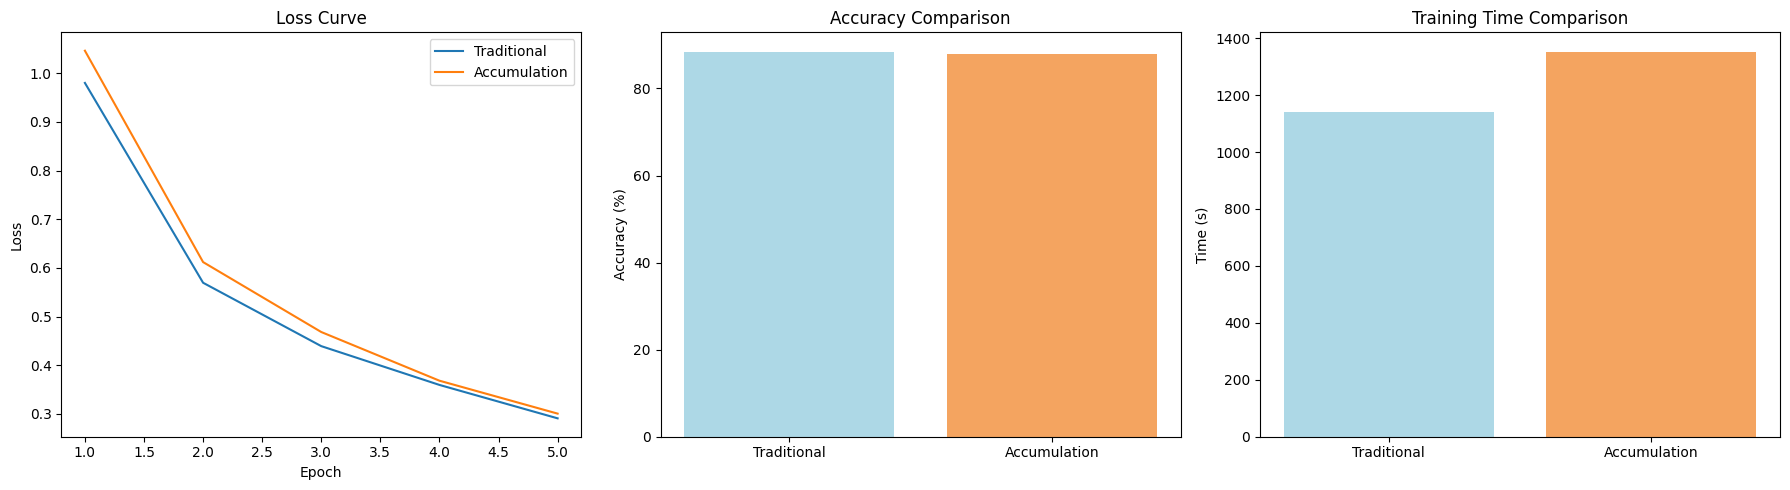

In [10]:
import matplotlib.pyplot as plt
# 驗證兩種方法的準確率
acc_traditional = evaluate_model(model_origin, test_loader)
acc_accumulation = evaluate_model(model_accumulation, test_loader)

# 繪製結果
plt.figure(figsize=(18, 5))

# Loss 曲線
plt.subplot(1, 3, 1)
plt.plot(range(1, epochs + 1), loss_traditional, label='Traditional')
plt.plot(range(1, epochs + 1), loss_accumulation, label='Accumulation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

# 準確率比較
plt.subplot(1, 3, 2)
methods = ['Traditional', 'Accumulation']
accuracies = [acc_traditional, acc_accumulation]
plt.bar(methods, accuracies, color=['lightblue', 'sandybrown'])
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Comparison')

# 訓練時間比較
plt.subplot(1, 3, 3)
times = [time_traditional, time_accumulation]
plt.bar(methods, times, color=['lightblue', 'sandybrown'])
plt.ylabel('Time (s)')
plt.title('Training Time Comparison')


plt.tight_layout()
plt.show()

<a id="ref2"></a>
# <h2 align=center>優化的梯度累積方法  </h2>


雖然從技術上來說，標準的梯度累積代碼在分布式環境中可以正常運行，但這並不是最有效的方法！
- `Accelerate`工具可以自動幫你追蹤目前訓練的批次數量，並根據需要自動執行優化器的更新，同時調整損失值，完全不需要你手動計算或設置。
- 在一般的梯度累積過程中，你通常需要自己調整步數，來反映累積批次數量的變化。但使用`Accelerate`，它會自動幫你處理這些細節。

<br>
huggingface官方提供了範例，使用 `Accelerate` 工具進行操作！
<br>
參考 https://huggingface.co/docs/accelerate/usage_guides/gradient_accumulation

In [11]:
from accelerate import Accelerator
from torch import optim
import time

model_accelerator=models.resnet101(weights=True)
model_accelerator.to(device)

# 設定加速器來處理梯度累積
accelerator = Accelerator(gradient_accumulation_steps=4)  # 每4步進行一次更新

# 準備模型、優化器和數據加載器
model_accelerator, optimizer_accumulation, train_loader_accumulation, scheduler_accumulation = accelerator.prepare(
    model_accelerator, optim.Adam(model_accelerator.parameters(), lr=learning_rate), train_loader_accumulation, None
)

c:\Users\tony1\anaconda3\envs\pytorch\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\tony1\anaconda3\envs\pytorch\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
# 定義訓練函數
def train_model_with_accelerate(model, train_loader, optimizer, criterion, accelerator):
    model.train()
    total_loss = []
    start_time = time.time()
    for epoch in range(epochs):
        running_loss = 0.0
        optimizer.zero_grad()
        for batch in train_loader:
            with accelerator.accumulate(model):
                inputs, labels = batch
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                accelerator.backward(loss)
                optimizer.step()
                optimizer.zero_grad()
                running_loss += loss.item()
        total_loss.append(running_loss / (len(train_loader)))
        print(f"Epoch {epoch + 1}, Loss: {total_loss[-1]:.4f}")
    
    total_time = time.time() - start_time
    return total_loss, total_time

In [13]:
# 訓練梯度累積方法
loss_accelerator, time_accelerator = train_model_with_accelerate(
    model_accelerator, train_loader_accumulation, optim.Adam(model_accelerator.parameters(), lr=learning_rate), criterion, accelerator
)

Epoch 1, Loss: 1.4766
Epoch 2, Loss: 0.9590
Epoch 3, Loss: 0.7092
Epoch 4, Loss: 0.5678
Epoch 5, Loss: 0.4719


<a id="ref3"></a>
# <h2 align=center>兩種方法比較  </h2>


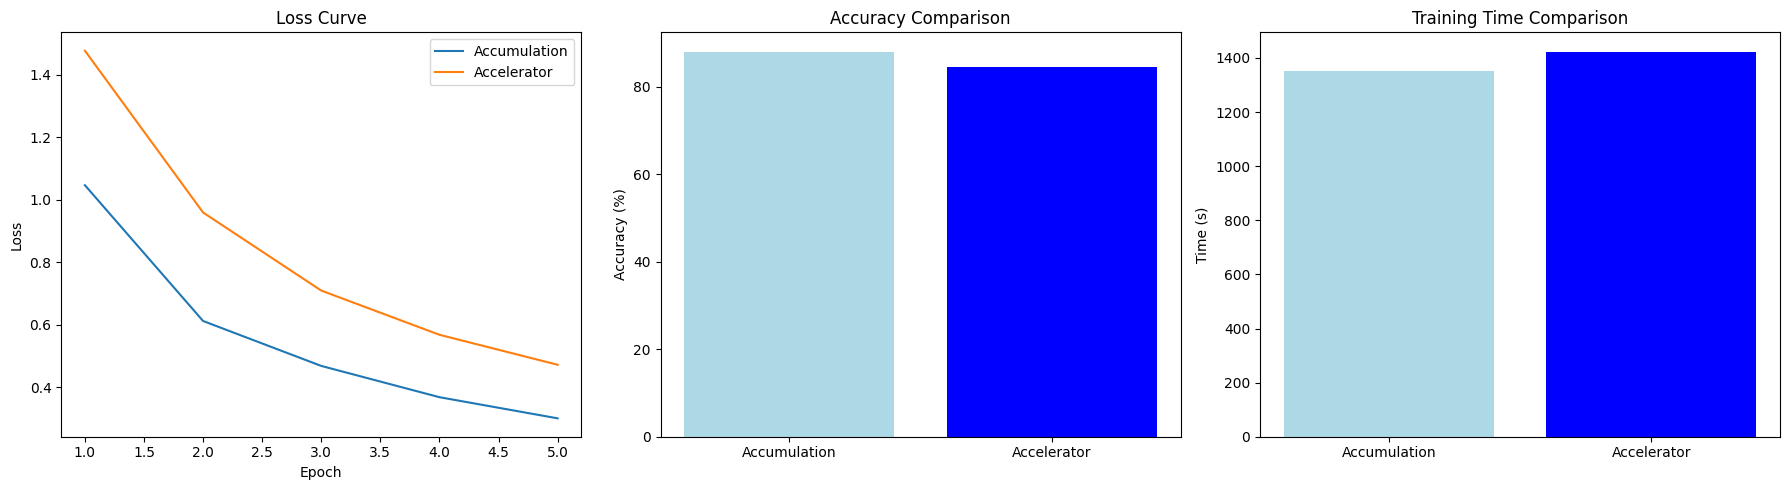

In [14]:
import matplotlib.pyplot as plt
# 驗證兩種方法的準確率
acc_accumulation = evaluate_model(model_accumulation, test_loader)
acc_accelerator = evaluate_model(model_accelerator, test_loader)

# 繪製結果
plt.figure(figsize=(18, 5))

# Loss 曲線
plt.subplot(1, 3, 1)
plt.plot(range(1, epochs + 1), loss_accumulation, label='Accumulation')
plt.plot(range(1, epochs + 1), loss_accelerator, label='Accelerator')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

# 準確率比較
plt.subplot(1, 3, 2)
methods = ['Accumulation', 'Accelerator']
accuracies = [acc_accumulation, acc_accelerator]
plt.bar(methods, accuracies, color=['lightblue', 'blue'])
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Comparison')

# 訓練時間比較
plt.subplot(1, 3, 3)
times = [time_accumulation, time_accelerator]
plt.bar(methods, times, color=['lightblue', 'blue'])
plt.ylabel('Time (s)')
plt.title('Training Time Comparison')


plt.tight_layout()
plt.show()